<a href="https://colab.research.google.com/github/Rohit1217/VGAN/blob/main/GANfc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import torch,torchvision
from torch.utils.data import DataLoader,TensorDataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets,transforms

In [ ]:
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True)

data=trainset.data
data=data.to(dtype=torch.float32)
norm = transforms.Normalize((128,),(128,))
data=norm(data)
#data=data*0.5+0.5

data_target=trainset.targets.to(dtype=torch.float32)
#data_target
data=data.view(60000,784)
data=data.to(dtype=torch.float32)
#data_target=data_target.view(60000,1,28,28)

trainset=TensorDataset(data,data)
trainloader=DataLoader(trainset,batch_size=64,shuffle=True)

In [ ]:
data[0]

tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.00

In [ ]:
Device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
l=10

In [ ]:
class generator(nn.Module):
  def __init__(self):
    super(generator,self).__init__()
    z=8
    l=100
    self.fc1=nn.Linear(l,32*z)
    self.fc3=nn.Linear(32*z,64*z)
    self.fc4=nn.Linear(64*z, 128*z)
    self.fc5=nn.Linear(128*z,784)

    self.bn1=nn.BatchNorm1d(16*z,0.8)
    self.bn2=nn.BatchNorm1d(32*z,0.8)
    self.bn3=nn.BatchNorm1d(64*z,0.8)
    self.bn4=nn.BatchNorm1d(128*z,0.8)

  def forward(self,b):
    x=torch.randn(b,100).to(Device)
    x=F.leaky_relu(self.bn2(self.fc1(x)),0.2,inplace=True)
    #x=F.leaky_relu(self.bn2(self.fc2(x)),0.2,inplace=True)
    x=F.leaky_relu(self.bn3(self.fc3(x)),0.2,inplace=True)
    x=F.leaky_relu(self.bn4(self.fc4(x)),0.2,inplace=True)
    x=F.tanh(self.fc5(x))
    return x
gen=generator().to(Device)
y=gen(2)
y.shape

torch.Size([2, 784])

In [ ]:
class discriminator(nn.Module):
  def __init__(self):
    super(discriminator,self).__init__()
    z=8
    self.fc1=nn.Linear(784,64*z)
    self.fc2=nn.Linear(64*z,32*z)
    self.fc3=nn.Linear(32*z,1)
    self.fc4=nn.Linear(4*z,1)

    self.bn2=nn.BatchNorm1d(32*z)
    self.bn3=nn.BatchNorm1d(4*z)
    self.bn4=nn.BatchNorm1d(z)

  def forward(self,x):
    x=F.leaky_relu(self.fc1(x),0.2,True)
    x=F.leaky_relu(self.bn2(self.fc2(x)),0.2,True)
    #x=F.leaky_relu(self.bn3(self.fc3(x)),0.2,True)
    #x=F.relu(self.bn4(self.fc4(x)))
    x=F.sigmoid(self.fc3(x))
    x=x.view(-1)
    return x
disc=discriminator().to(Device)
disc(y)

tensor([0.4960, 0.4165], device='cuda:0', grad_fn=<ViewBackward0>)

In [ ]:
epochs=100
gen=generator().to(Device)
disc=discriminator().to(Device)
optimizer=optim.Adam(gen.parameters(),lr=0.0002,betas=(0.5,0.999))
optimizer2=optim.Adam(disc.parameters(),lr=0.0002,betas=(0.5,0.999))
criterion=nn.BCELoss()

In [ ]:
for epoch in range(epochs):
  disc_loss=0
  gen_loss=0
  count=0
  for input,_ in trainloader:
    input=input.to(Device)
    b,c=input.shape

    optimizer2.zero_grad()

    real_label=torch.ones(b).to(Device)
    real_out=disc(input)
    loss_d_real=criterion(real_out,real_label)
    #loss_d_real.backward()

    fake_label=torch.zeros(b).to(Device)
    fake_input=gen(b)
    fake_out=disc(fake_input)
    loss_d_fake=criterion(fake_out,fake_label)
    #loss_d_fake.backward()
    loss1=(loss_d_real+loss_d_fake)/2

    disc_loss+=loss_d_real+loss_d_fake
    loss1.backward()
    optimizer2.step()



    optimizer.zero_grad()
    y=gen(b)
    label=torch.ones(b).to(Device)
    gen_out=disc(y)
    loss_gen=criterion(gen_out,label)
    gen_loss+=loss_gen.item()
    #print(loss_gen)
    #print(real_label,fake_label,label,real_out,fake_out,gen_out)

    loss_gen.backward()
    optimizer.step()

    count+=1



    #print(disc_loss,gen_loss)

  print(f'epoch={epoch},total_gen_loss={gen_loss},total_disc_loss={disc_loss},mean_gen_loss={gen_loss/count},mean_disc_loss={disc_loss/count}')



epoch=0,total_gen_loss=1023.5569691061974,total_disc_loss=887.2257080078125,mean_gen_loss=1.0912121205823,mean_disc_loss=0.9458696246147156
epoch=1,total_gen_loss=1291.0830404758453,total_disc_loss=715.1580810546875,mean_gen_loss=1.3764211518932252,mean_disc_loss=0.7624287009239197
epoch=2,total_gen_loss=1254.6414985656738,total_disc_loss=754.2230224609375,mean_gen_loss=1.3375708939932556,mean_disc_loss=0.8040757179260254
epoch=3,total_gen_loss=1212.4238077402115,total_disc_loss=801.9065551757812,mean_gen_loss=1.2925626948189888,mean_disc_loss=0.8549110889434814
epoch=4,total_gen_loss=1188.433651804924,total_disc_loss=841.9869384765625,mean_gen_loss=1.2669868356129255,mean_disc_loss=0.8976407051086426
epoch=5,total_gen_loss=1165.2460045814514,total_disc_loss=868.000732421875,mean_gen_loss=1.2422665294045325,mean_disc_loss=0.925373911857605
epoch=6,total_gen_loss=1158.6878031492233,total_disc_loss=879.6066284179688,mean_gen_loss=1.2352748434426688,mean_disc_loss=0.9377469420433044
epoch

KeyboardInterrupt: 

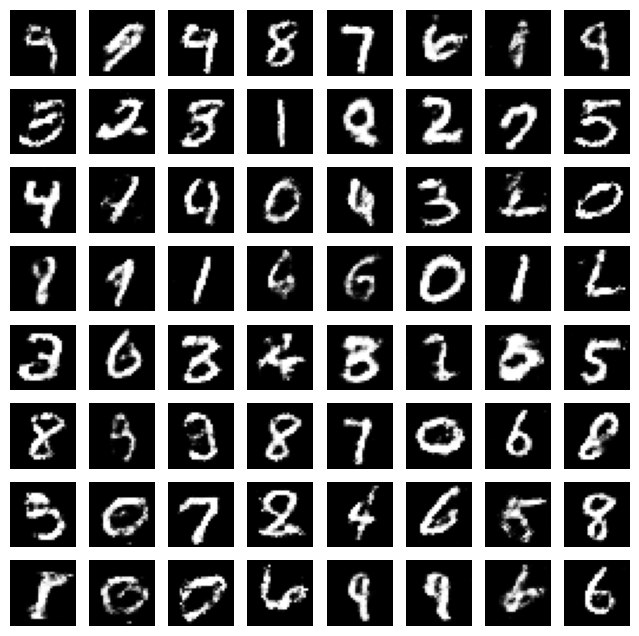

In [ ]:
with torch.no_grad():
  #gen.eval()
  z=gen(128)
  z=z[:64]
  x = z.view(8, 8, 28, 28)
  x = x.to('cpu')
  image_np = x.numpy()

  # Create a figure and a set of subplots arranged in an 8x8 grid
  fig, axes = plt.subplots(8, 8, figsize=(8, 8))

  # Iterate through the subplots and display each image
  for i in range(8):
      for j in range(8):
          axes[i, j].imshow(image_np[i, j], cmap='gray')
          axes[i, j].axis('off')  # Turn off axis labels

  plt.show()

In [ ]:
#z=data[:128].to(Device)
y=disc(z)
y

tensor([0.2675, 0.3489, 0.1455, 0.6664, 0.4449, 0.5596, 0.1579, 0.3802, 0.1222,
        0.1971, 0.4826, 0.0971, 0.3494, 0.2244, 0.2042, 0.5851, 0.3485, 0.4009,
        0.3112, 0.4085, 0.1365, 0.1511, 0.0306, 0.6514, 0.2662, 0.3424, 0.1953,
        0.4548, 0.4795, 0.2699, 0.4337, 0.2426, 0.2205, 0.2968, 0.3215, 0.2223,
        0.4291, 0.4393, 0.3017, 0.7626, 0.3377, 0.3249, 0.1614, 0.1838, 0.5093,
        0.5766, 0.2035, 0.2072, 0.2603, 0.1731, 0.1467, 0.1968, 0.2444, 0.1560,
        0.7426, 0.3193, 0.2034, 0.4350, 0.2925, 0.5364, 0.4847, 0.2894, 0.2819,
        0.5506], device='cuda:0', grad_fn=<ViewBackward0>)